In [1]:
import numpy as np
from ipywidgets import *
import matplotlib.pyplot as plt
import datetime
from mpl_toolkits.basemap import Basemap, shiftgrid
import pygrib
import glob
import string
from shapely.geometry import Point, mapping
from fiona import collection
from ipywidgets import widgets

%matplotlib notebook

In [2]:
from gribapi import *
from redtoreg import _redtoreg
from pygrib import gaulats

def gridd(lon1,lat1,lon2,lat2,nlats):

        #   lon1, lat1 = self.longitude_first_gridpoint, self.latitude_first_gridpoint
        #   lon2, lat2 = self.longitude_last_gridpoint, self.latitude_last_gridpoint
        #   nlats = self.points_in_y_direction
            # ECMWF 'reduced' gaussian grid.
            nlons = 2*nlats
            delon = 360./nlons
        #   lons = np.arange(lon1,lon2,delon)
            lons = np.linspace(lon1,lon2,nlons)
            # compute gaussian lats (north to south)
            lats = gaulats(nlats)
            if lat1 > lat2 :
               lats = lats[::-1]
          # lons = lons[::-1]
            lons,lats = np.meshgrid(lons,lats) # make 2-d arrays

            return lons,lats


def getd(INPUT,time):
    f = open(INPUT)

    for t in range(3*time):
        gid = grib_new_from_file(f)#,headers_only = True)
        grib_release(gid)
    dat={}
    for l in range(3):
        gid = grib_new_from_file(f)
        if gid is None:            
            print 'time = {}, gid = None'.format(t)
            break


        name=grib_get(gid, 'shortName')
        mv=grib_get(gid,'missingValue')

        lonfgp=grib_get(gid,'longitudeOfFirstGridPointInDegrees')
        latfgp=grib_get(gid,'latitudeOfFirstGridPointInDegrees')
        lonlgp=grib_get(gid,'longitudeOfLastGridPointInDegrees')
        latlgp=grib_get(gid,'latitudeOfLastGridPointInDegrees')
       
        if grib_get(gid,'gridType') == 'regular_gg':

          Ni=grib_get(gid,'Ni')
          Nj=grib_get(gid,'Nj')
          lat=grib_get_array(gid,'latitudes')
          lat=lat.reshape(Nj,Ni)
          lat=np.flipud(lat)
          lon=grib_get_array(gid,'longitudes')
          lon=lon.reshape(Nj,Ni)

          values=grib_get_values(gid)
          dat[name]=values.reshape(Nj,Ni)
        
        elif grib_get(gid,'gridType') == 'reduced_gg' :

          ss=grib_get_array(gid,'pl')  # lons per lat for the reduced_gg grid
          lon,lat = gridd(lonfgp,latfgp,lonlgp,latlgp,ss.size)

          values=grib_get_values(gid)
          ny=2*np.size(ss)

          dat[name]=_redtoreg(ny,ss,values,mv)

        grib_release(gid)

    f.close()

    return dat,lat,lon



In [3]:
# MAP WINDOW
minlat=29.5
maxlat=48
minlon=-5.5
maxlon=42.

In [4]:
def wmap(yyyy,mm,dd,hh,time,save=False):
    hh=np.int(hh) # The variables are passed as string and needs to become integer to be used later
    yyyy=np.int(yyyy)
    mm=np.int(mm)
    dd=np.int(dd)
    time=np.int(time)
    # specify date to plot.
    date = datetime.datetime(yyyy,mm,dd,hh)

    # set PATH of the database.
    PATHbase="/mnt/ECMWF/grib/"  # Local mapping location for the above network drive
    PATH=PATHbase+"%04i/%02i/%02i/" % (yyyy,mm,dd)

    dpath=glob.glob(PATH+"*%04i%02i%02i.%02i.tropical_cyclone.grib" % (yyyy,mm,dd,hh))

    try:
        data,lat,lon = getd(dpath[0],time)
    except:
        print 'no available data in ', PATH
        return

    pd=data['msl']
    ud=data['10u']
    vd=data['10v']
    # read lats,lons
    # reverse latitudes so they go from south to north.
    latitudes = lat[:,0]
    longitudes = lon[0,:]
    # get sea level pressure and 10-m wind data.
    # mult slp by 0.01 to put in units of hPa
    slpin = 0.01*pd.squeeze()
    uin = ud.squeeze()
    vin = vd.squeeze()


    # add cyclic points manually (could use addcyclic function)
    slp= np.zeros((slpin.shape[0],slpin.shape[1]+1),np.float64)
    slp[:,0:-1] = slpin[::-1]; slp[:,-1] = slpin[::-1,0]
    u= np.zeros((uin.shape[0],uin.shape[1]+1),np.float64)
    u[:,0:-1] = uin[::-1]; u[:,-1] = uin[::-1,0]
    v= np.zeros((vin.shape[0],vin.shape[1]+1),np.float64)
    v[:,0:-1] = vin[::-1]; v[:,-1] = vin[::-1,0]

    longitudes=np.append(longitudes,360.)

    lons, lats = np.meshgrid(longitudes,latitudes)

    # make orthographic basemap.
    m = Basemap(projection='cyl',llcrnrlat=minlat,urcrnrlat=maxlat,\
             llcrnrlon=minlon,urcrnrlon=maxlon,resolution='c')
    # create figure, add axes
    plt.figure(figsize=(10,8))
    # set desired contour levels.
    clevs = np.arange(960,1061,5)

    # compute native x,y coordinates of grid.
    x, y = m(lons, lats)
    # define parallels and meridians to draw.
    parallels = np.arange(-90.,90,20.)
    meridians = np.arange(0.,360.,20.)
    # plot SLP contours.
 #   slpg,newlons = shiftgrid(180.,slp,longitudes,start=False)
 #   slpd,xx,yy = \
 #   m.transform_scalar(slpg,newlons,latitudes,181,181,returnxy=True,masked=True)
 #   CS1 = m.contour(x,y,slp,clevs,linewidths=0.5,colors='k',animated=True)
 #   CS2 = m.contourf(x,y,slp,clevs,cmap=plt.cm.RdBu_r,animated=True)
    # plot wind vectors on projection grid.
    # first, shift grid so it goes from -180 to 180 (instead of 0 to 360
    # in longitude).  Otherwise, interpolation is messed up.
    ugrid,newlons = shiftgrid(180.,u,longitudes,start=False)
    vgrid,newlons = shiftgrid(180.,v,longitudes,start=False)
    # transform vectors to projection grid.
    uproj,vproj,xx,yy = \
    m.transform_vector(ugrid,vgrid,newlons,latitudes,81,81,returnxy=True,masked=True)
    # now plot.
    vel=np.sqrt(uproj**2+vproj**2)
    CS1 = m.contour(xx,yy,vel,10,linewidths=0.5,colors='k',animated=True)
    CS2 = m.contourf(xx,yy,vel,10,cmap=plt.cm.RdBu_r,animated=True)

    
    Q = m.quiver(xx,yy,uproj,vproj,scale=700)
    # make quiver key.
    qk = plt.quiverkey(Q, 0.1, 0.1, 20, '20 m/s', labelpos='W')
    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5)
    m.drawparallels(parallels)
    m.drawmeridians(meridians)
    # add colorbar
    cb = m.colorbar(CS2,"right", size="5%", pad="2%")
    cb.set_label('m/s')
    # set plot title
    plt.title('Wind Speed at '+ datetime.datetime.strftime(date+datetime.timedelta(hours=time), '%a %b %d  %H:%M:%S %Z %Y')+'    Max wind={:.4g}'.format(vel.max()))
    
    #compute direction
    
    theta=(180./np.pi)*np.arctan2(uproj,vproj)

    if save :
    #write to shapefile
     loc=zip(xx.flatten(),yy.flatten(),vel.flatten(),theta.flatten())
    
     filename=datetime.datetime.strftime(date+datetime.timedelta(hours=time), '%Y%m%d%H')
    
     schema = { 'geometry': 'Point', 'properties': { 'vel': 'float', 'dir': 'float' } }
     with collection("tmp/"+filename+".shp", "w", "ESRI Shapefile", schema) as output:
        for x,y,v,th in loc:
            point = Point(x,y)
            output.write({
                'properties': {
                    'vel': v,
                    'dir': th
                },
                'geometry': mapping(point)
            })

    
    plt.show()
    return #xx,yy,vel,theta

<IPython.core.display.Javascript object>


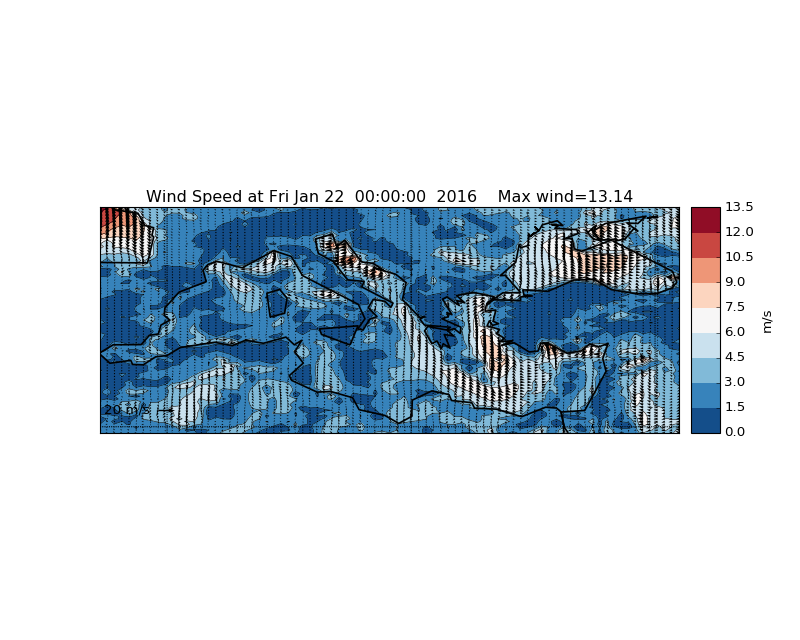

In [5]:
 wmap(yyyy=2016, mm=1, dd=20, hh=0, time=48)

In [6]:
# Define range of file attributes
yy=[2015,2016]
yy=[w for w in map(str,yy )]
mm=np.arange(1,13)
mm=[w for w in map(str,mm )]
dd=np.arange(1,32)
dd=[w for w in map(str,dd )]
hh=[0,12]
hh=[w for w in map(str,hh )]
tt=np.arange(0,73)
tt=[w for w in map(str,tt )]



<IPython.core.display.Javascript object>


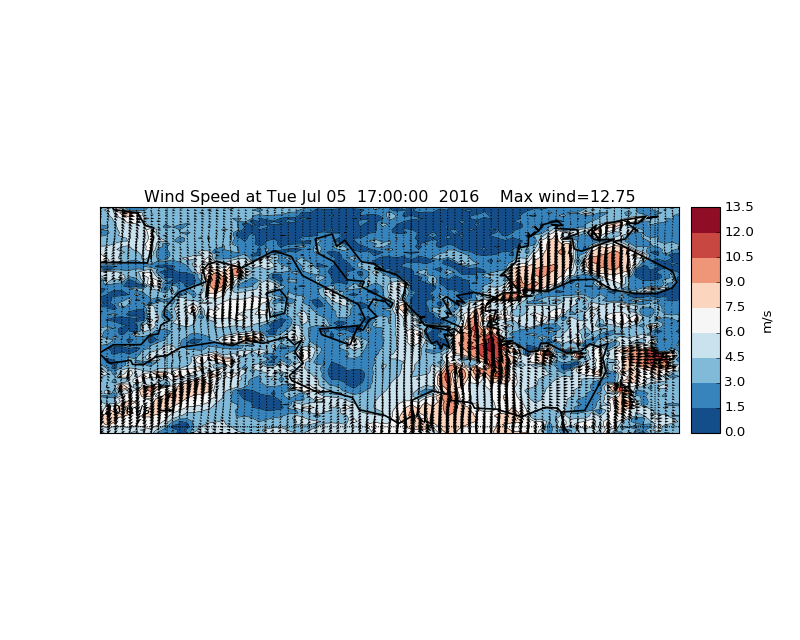

In [7]:
interact_manual(wmap, yyyy=yy, mm=mm, dd=dd, hh=hh, time=tt, save=widgets.Checkbox())